---

<h1 style="text-align:center;">Value at Risk (VaR) and Expected Shortfall (ES) on an optimized portfolio (CAPM)</h1>

---

Import the necessary libraries.

In [358]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.optimize as sco

Set the time range for a certain amount of years.

In [359]:
years     = 5
endDate   = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

Create a list of ticker.

Download the daily adjusted close prices for each of these tickers.

[Voir Annexes 1](#annexes1)

In [360]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start=startDate, end=endDate, auto_adjust=True)
    adj_close_df[ticker] = data['Close']

adj_close_df.head(n=5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2020-10-01,314.209198,76.187897,178.699997,273.759949,159.844162
2020-10-02,311.225952,76.136093,178.539993,266.058807,158.596909
2020-10-05,316.744965,75.850868,179.410004,271.732880,161.454407
2020-10-06,312.242126,75.954605,177.300003,266.883270,159.462540
2020-10-07,317.677216,75.850868,177.220001,271.500153,162.245621


Calculate the daily log returns

Drop any NAs.

[Voir Annexes 2](#annexes2)

In [361]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

log_returns = log_returns.dropna()

log_returns.head(n=5)

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2020-10-02,-0.009540,-0.000680,-0.000896,-0.028534,-0.007834
2020-10-05,0.017578,-0.003753,0.004861,0.021102,0.017857
2020-10-06,-0.014318,0.001367,-0.011830,-0.018008,-0.012414
2020-10-07,0.017257,-0.001367,-0.000451,0.017151,0.017302
2020-10-08,0.008823,0.001708,0.003549,0.005309,0.008739


Build an efficient portfolio according to Markowitz portfolio theory

[Voir Annexes 3](#annexes3)

https://www.investopedia.com/terms/c/capm.asp#toc-the-capm-and-the-efficient-frontier (CAPM)

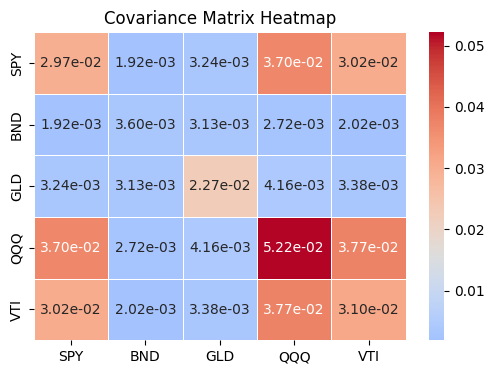

In [362]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cov_matrix, annot=True, fmt=".2e", cmap="coolwarm", center=cov_matrix.values.mean(), linewidths=0.5)

plt.title("Covariance Matrix Heatmap")
plt.show()

In [363]:
risk_free_rate = 0.02

cov_matrix = log_returns.cov() * 252

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return - (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 1) for _ in range(len(tickers))]

initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = sco.minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = - neg_sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.4562
BND: 0.0000
GLD: 0.5438
QQQ: 0.0000
VTI: 0.0000
Expected Annual Return: 0.1433
Expected Volatility: 0.1205
Sharpe Ratio: 1.0230


Set hyperparameters

In [364]:
portfolio_value = 1000000

confidence_levels = [0.9, 0.95, 0.99]

days = 1

Calculate the historical X-days portfolio returns based on our optimized portfolio.

[Voir Annexes 4](#annexes4)

In [365]:
historical_returns = (log_returns * weights).sum(axis=1)

historical_x_day_returns = historical_returns.rolling(window = days).sum()
historical_x_day_returns = historical_x_day_returns.dropna()

Calculate historical VaR and ES.

[Voir Annexes 5](#annexes5)

In [366]:
VaRs = []
ESs = []

for level in confidence_levels:
    thereshold = np.percentile(historical_x_day_returns, 100 - (level*100))
    VaR = -thereshold*portfolio_value
    ES = -historical_x_day_returns[historical_x_day_returns <= thereshold].mean() * portfolio_value
    VaRs.append(VaR)
    ESs.append(ES)

# Print table headers
print(f'{"Confidence Level":<20} {"Value at Risk":<20} {"Expected Shortfall":<20}')
print('-' * 70)

# Print each confidence level and its corresponding VaR & ES values
for level, VaR, ES in zip(confidence_levels, VaRs, ESs):
    print(f'{level * 100:>6.0f}%: {"":<5} ${VaR:>12,.2f} {"":<5} ${ES:>12,.2f}')

Confidence Level     Value at Risk        Expected Shortfall  
----------------------------------------------------------------------
    90%:       $    9,926.17       $   16,227.05
    95%:       $   14,050.69       $   20,492.50
    99%:       $   24,527.13       $   30,800.85


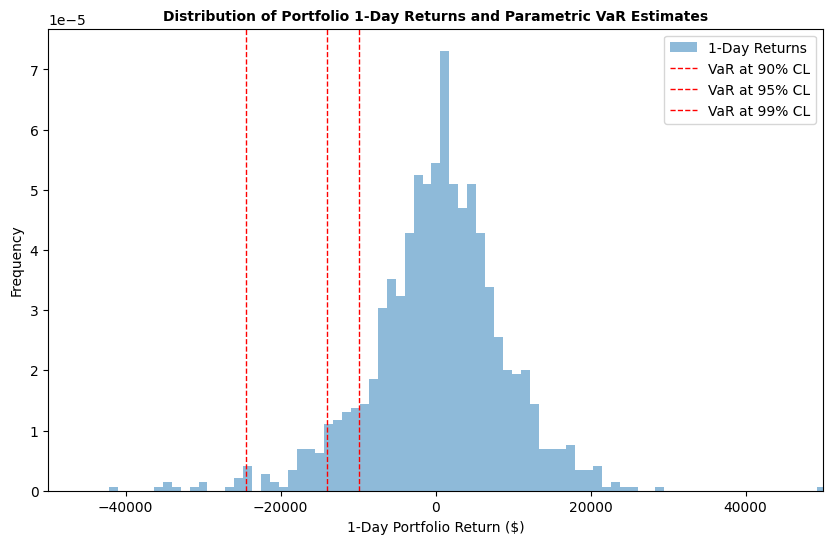

In [367]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=100, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add Value at Risk (VaR) line at each confidence level
for level, VaR in zip(confidence_levels, VaRs):
    plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=1, label=f'VaR at {int(level * 100)}% CL')

# Formatting labels and title
plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates', fontsize=10, fontweight='bold')

plt.xlim(left=-50000, right=50000)
plt.legend()
plt.show()

Calculate parametric VaR and ES

[Voir Annexes 6](#annexes6)

In [368]:
from scipy.stats import norm

portfolio_std_dev = standard_deviation(optimal_weights, cov_matrix)

VaRs = []
ESs = [0,0,0]

for level in confidence_levels:
    VaR = portfolio_value * portfolio_std_dev * norm.ppf(level) * np.sqrt(days / 252)
    VaRs.append(VaR)

# Print table headers
print(f'{"Confidence Level":<20} {"Value at Risk":<20} {"Expected Shortfall":<20}')
print('-' * 70)

# Print each confidence level and its corresponding VaR & ES values
for level, VaR, ES in zip(confidence_levels, VaRs, ESs):
    print(f'{level * 100:>6.0f}%: {"":<5} ${VaR:>12,.2f} {"":<5} ${ES:>12,.2f}')

Confidence Level     Value at Risk        Expected Shortfall  
----------------------------------------------------------------------
    90%:       $    9,726.26       $        0.00
    95%:       $   12,483.52       $        0.00
    99%:       $   17,655.68       $        0.00


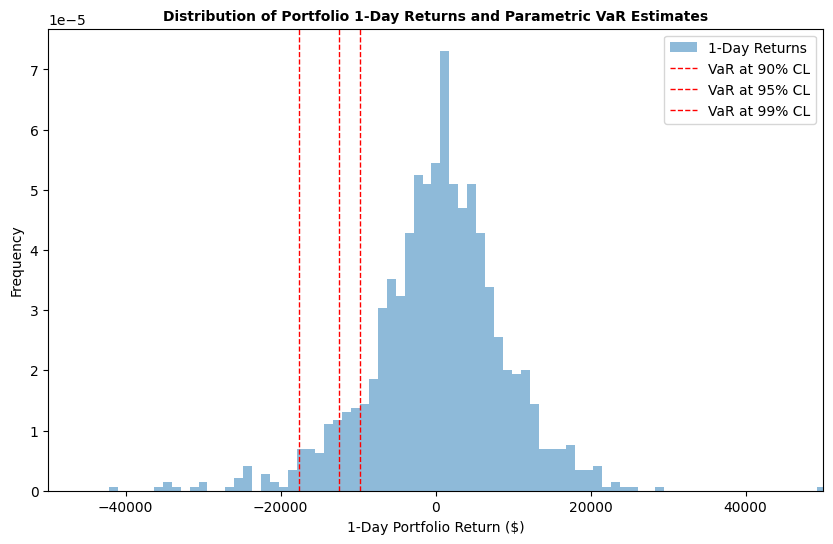

In [369]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=100, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add Value at Risk (VaR) line at each confidence level
for level, VaR in zip(confidence_levels, VaRs):
    plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=1, label=f'VaR at {int(level * 100)}% CL')

# Formatting labels and title
plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates', fontsize=10, fontweight='bold')

plt.xlim(left=-50000, right=50000)
plt.legend()
plt.show()

The histogram represents the **theoretical distribution of portfolio returns over 5 days** using the **parametric (variance-covariance) approach**. The **blue bars** show the **frequency of different gain/loss scenarios**, assuming a **normal distribution of returns** based on historical volatility. The **three red dashed lines** indicate the **Value at Risk (VaR) thresholds** at **90%, 95%, and 99% confidence levels**, representing the **worst expected losses under each probability level**. Unlike the Monte Carlo approach, which simulates returns, this method directly calculates risk using **portfolio standard deviation and Z-scores from the normal distribution**. This visualization helps assess **downside risk**, illustrating both **typical portfolio behavior** and the **potential for extreme losses based on statistical assumptions**.

Calculate monte carlo VaR and ES.

[Voir Annexes 7](#annexes7)

In [370]:
def random_z_score():
    """
    Generates a random Z-score from a standard normal distribution.

    Returns:
    -------
    float
        A randomly sampled value from a standard normal distribution (mean = 0, std = 1).
    """
    return np.random.normal(0, 1)

def scenario_gain_loss(portfolio_value, portfolio_expected_return, portfolio_std_dev, z_score, days):
    """
    Estimates the potential gain or loss of a portfolio over a given time horizon using 
    expected returns and volatility.

    Parameters:
    ----------
    portfolio_value : float
        The current value of the portfolio.

    portfolio_expected_return : float
        The expected daily return of the portfolio.

    portfolio_std_dev : float
        The standard deviation (volatility) of the portfolio returns.

    z_score : float
        The Z-score representing the number of standard deviations away from the mean 
        in a normal distribution.

    days : int
        The time horizon (number of days) over which the scenario is projected.

    Returns:
    -------
    float
        The projected portfolio value change over the given period, incorporating both 
        expected returns and volatility.
    """
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [371]:
portfolio_expected_return = expected_return(optimal_weights, log_returns)
portfolio_std_dev         = standard_deviation(optimal_weights, cov_matrix)
simulations = 1000000
scenarioReturn = []

for i in range(simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_expected_return, portfolio_std_dev, z_score, days))

VaRs = []
ESs = [0,0,0]

for level in confidence_levels:
    VaR = np.percentile(scenarioReturn, 100 * (1 - level))
    VaRs.append(VaR)

# Print table headers
print(f'{"Confidence Level":<20} {"Value at Risk":<20} {"Expected Shortfall":<20}')
print('-' * 70)

# Print each confidence level and its corresponding VaR & ES values
for level, VaR, ES in zip(confidence_levels, VaRs, ESs):
    print(f'{level * 100:>6.0f}%: {"":<5} ${VaR:>12,.2f} {"":<5} ${ES:>12,.2f}')

Confidence Level     Value at Risk        Expected Shortfall  
----------------------------------------------------------------------
    90%:       $  -10,969.04       $        0.00
    95%:       $  -54,652.90       $        0.00
    99%:       $ -137,456.52       $        0.00


The histogram represents the **simulated distribution of portfolio returns over 5 days** using a Monte Carlo approach. The blue bars show the **frequency of different gain/loss scenarios**, with most returns centered around the mean, forming a normal-like shape. The **red dashed line** marks the **Value at Risk (VaR) at 95% confidence**, indicating the **5% worst expected loss**. The **shaded red area** highlights these extreme loss scenarios, meaning there is a **5% probability of losing more than this amount**. This visualization helps assess downside risk, showing both typical portfolio behavior and worst-case losses.

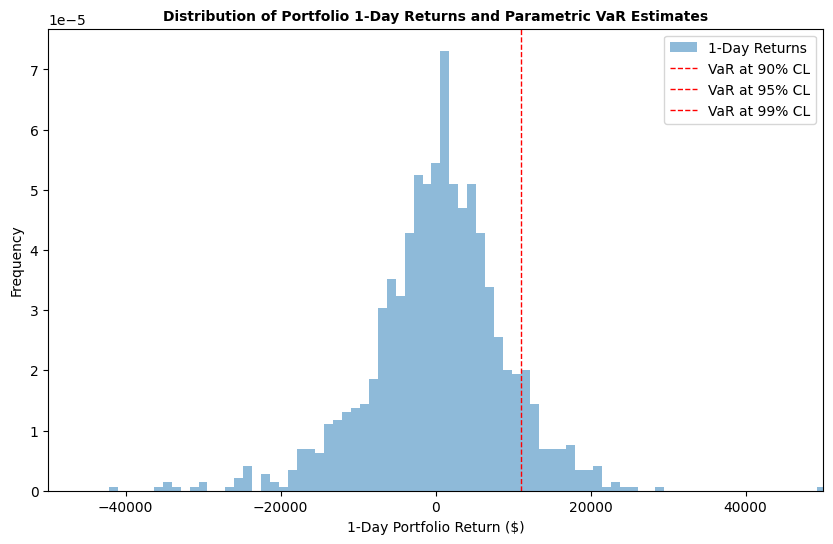

In [372]:
# Convert returns to dollar values for the histogram
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(historical_x_day_returns_dollar, bins=100, density=True, alpha=0.5, label=f'{days}-Day Returns')

# Add Value at Risk (VaR) line at each confidence level
for level, VaR in zip(confidence_levels, VaRs):
    plt.axvline(-VaR, color='red', linestyle='dashed', linewidth=1, label=f'VaR at {int(level * 100)}% CL')

# Formatting labels and title
plt.xlabel(f'{days}-Day Portfolio Return ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio {days}-Day Returns and Parametric VaR Estimates', fontsize=10, fontweight='bold')

plt.xlim(left=-50000, right=50000)
plt.legend()
plt.show()

# Annexes 1 <a id="annexes1"></a>

SPY = Largest S&P-500 ETF \
BND = Largest bond market ETF \
GLD = Largest commodity-based ETF that tracks the price of Gold \
QQQ = Largest Nasdaq ETF \
VTI = Vanguard's all-world stock index 

We use adjusted close prices rather than normal ones because adjusted close prices account for dividends stock splits and our analysis will be more accurate by incorporating those.

# Annexes 2 <a id="annexes2"></a>

The simple return (or percentage change) is calculated as:

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

where:
- $R_t$ is the return for day \( t \),
- $P_t$ is the price at day \( t \),
- $P_{t-1}$ is the price at the previous day.

The log return is defined as:

$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right)
$$

where $\ln$ represents the natural logarithm.

Why Use Log Returns? Logarithmic returns have an important property: they are additive over time.

For example, given two consecutive days' returns:

$$
r_t = \ln \left(\frac{P_t}{P_{t-1}}\right), \quad r_{t+1} = \ln \left(\frac{P_{t+1}}{P_t}\right)
$$

Adding these two:

$$
r_t + r_{t+1} = \ln \left(\frac{P_t}{P_{t-1}}\right) + \ln \left(\frac{P_{t+1}}{P_t}\right)
$$

Using the logarithmic property:

$$
\ln a + \ln b = \ln (a \times b)
$$

we get:

$$
r_t + r_{t+1} = \ln \left(\frac{P_{t+1}}{P_{t-1}}\right)
$$

This means that log returns can be directly summed over multiple periods, making them convenient for time-series analysis, portfolio aggregation, and statistical modeling. In contrast, simple returns are not additive but must be compounded, making calculations more complex when dealing with multiple periods.


# Annexes 3 <a id="annexes3"></a>

Markowitz Portfolio Theory

1. Form expectations: The investor starts by forming beliefs about future asset returns, based on data or judgment.

2. Select the optimal portfolio: Using these expectations, the goal is to either maximize expected return for a given level of risk (variance) or minimize risk for a given expected return.

According to the theory, portfolio risk depends on:

- the individual variances of each asset,

- the covariances between assets — which is why diversifying across weakly correlated assets matters.

Markowitz distinguishes:

- The set of feasible portfolios: all portfolios that meet constraints (e.g. budget, no short selling).

- The efficient frontier: portfolios that are optimal — no other portfolio offers higher expected return with lower risk.

Key insights:

- Diversification lowers risk, but only if the assets aren’t perfectly correlated.

- What matters isn’t the number of assets, but how weakly correlated they are (e.g., stocks from different sectors).

---

### 1. Portfolio Volatility

Portfolio standard deviation (volatility) is given by:

$$
\sigma(w) = \sqrt{w^T \Sigma w}
$$

where:

- $w$ : Weights
- $\Sigma$ : Covariance matrix

### 2. Sharpe Ratio

$$ \text{Sharpe}(w) = \frac{\mathbb{E}[R_p] - R_f}{\sigma(w)} $$

where:

- $\mathbb{E}[R_p]$ : Expected annual return of the portfolio
- $R_f$ : Risk free rate

### 3. Optimization Problem

We solve:

$$
\min_{w} \left( -\frac{\mathbb{E}[R_p] - R_f}{\sqrt{w^T \Sigma w}} \right)
$$

under the constraints :

- Total budget constraint:

$ \sum_{i=1}^{N} w_i = 1 $

- No short selling:

$ 0 \leq w_i \leq 1 \quad \forall i $

# Annexes 4 <a id="annexes4"></a>

We aim to compute the rolling cumulative returns over a specified period (X days), allowing us to analyze short-term return trends instead of just daily fluctuations.

We first calculate the daily weighted portfolio returns:

$$
\text{historical returns} = \sum_{i=1}^{n} w_i \cdot r_i
$$

where:
- $w_i$ = portfolio weight of asset $i$,
- $r_i$ = daily log return of asset $i$,
- The sum is taken across all assets for each day.

In order to find the X-days historical returns, we:

- Set a X-day period.
- Create a DataFrame based on X-days rolling returns.

To compute X-day cumulative returns, we use a rolling sum over the daily returns:

$$
R_t = \sum_{j=t-X+1}^{t} r_j
$$

where:
- $R_t$ is the X-day cumulative return at time $t$,
- $r_j$ are the individual daily returns in the rolling window,
- The window moves day by day, always summing the last X days.

Why Use a Rolling Sum?
- Smooths out daily volatility by aggregating past returns.
- Reveals short-term trends in portfolio performance.
- Useful for risk and momentum analysis in trading and investment strategies.

# Annexes 5 <a id="annexes5"></a>

The general mathematical definition of VaR at a confidence level 1 - \alpha$ is:

$$
VaR_{1-\alpha}(X) := \inf \{ t \in \mathbb{R} : \textbf{P}(X \leq t) \geq 1 - \alpha \}
$$

where:
- $X$ represents the distribution of portfolio returns,
- $t$ is the threshold return (percentile cutoff),
- $\alpha$ is the significance level (e.g., 5% for a 95% confidence interval),
- $1 - \alpha$ is the confidence level (e.g., 95%),
- The infimum (inf) ensures we take the smallest possible value meeting the probability condition.

Formula Used in the Historical Method: The historical method directly takes past return data and calculates the percentile corresponding to the chosen confidence level. The formula is:

$$
VaR = -\text{Percentile} ( X, 100 \times (1 - \alpha) ) \times \text{Portfolio Value} 
$$

where:
- $X$ is the historical return distribution,
- $\alpha$ is the significance level,
- $\text{Percentile} (X, 100 \times (1 - \alpha))$ gives the cutoff return for the worst $\alpha$% of cases,
- The negative sign ensures that VaR is expressed as an absolute loss.

---

The general mathematical definition of Expected Shortfall (ES), also known as Conditional Value at Risk (CVaR), at a confidence level $ 1 - $\alpha$ $ is:

$$
ES_{1-\alpha}(X) := \mathbb{E}[X \mid X \leq VaR_{1-\alpha}(X)]
$$

where:
- $ X $ is the distribution of portfolio returns,  
- $ VaR_{1-\alpha}(X) $ is the Value at Risk at confidence level $ 1 - \alpha $,  
- $ \mathbb{E}[X \mid X \leq VaR] $ denotes the expected value of returns in the worst $ \alpha $% of cases.  

Formula Used in the Historical Method:  
The historical method estimates ES by averaging the worst $ \alpha $% of returns in the historical data. The formula is:

$$
ES = -\frac{1}{n_\alpha} \sum_{i=1}^{n_\alpha} X_{(i)} \times \text{Portfolio Value}
$$

where:
- $ X_{(i)} $ are the ordered returns from worst to best (i.e., $ X_{(1)} \leq X_{(2)} \leq \dots \leq X_{(n)} $),  
- $ n_\alpha = \lfloor \alpha \times n \rfloor $ is the number of worst-case scenarios to average,  
- The negative sign expresses ES as an expected loss.  

Expected Shortfall provides a more coherent and informative risk measure than VaR by accounting not only for the threshold loss but also for the average severity of losses beyond that threshold.


# Annexes 6 <a id="annexes6"></a>

Calculate **VaR** for different confidence levels.

**Parametric (Variance-Covariance) Method**: This approach assumes that portfolio returns are **normally distributed**, allowing us to estimate VaR using the portfolio's **standard deviation** and a **Z-score** corresponding to the confidence level.

The **formula** for parametric VaR is:

$$
VaR = P_0 \cdot \sigma_p \cdot Z_{\alpha} \cdot \sqrt{\frac{T}{252}}
$$

where:
- $P_0$ = **portfolio value**
- $\sigma_p$ = **portfolio standard deviation**
- $Z_{\alpha}$ = **Z-score corresponding to the confidence level $\alpha$**
- $T$ = **time horizon (number of days)**
- **252** = Trading days in a year (used to annualize volatility)

**1. Portfolio Value $P_0$**: We express VaR in **monetary terms** by multiplying by $P_0$, since we want the final result to be a **dollar amount (or other currency)**.

**2. Volatility $\sigma_p$**: The standard deviation $\sigma_p$ tells us **how much the portfolio's returns fluctuate on average**. Higher volatility means **higher risk**, so it naturally **scales our risk estimate**.

**3. Scaling for Time Horizon $\frac{T}{252}$**: Volatility is **annualized**, meaning it represents **1 year of risk**. If we want VaR for $T$ days, we adjust using:

$$
\text{Volatility over T days} = \sigma_p \cdot \sqrt{\frac{T}{252}}
$$

This follows from the **square-root rule of time scaling**, which assumes **returns scale with the square root of time** (a property of **Brownian motion in finance**).

**4. Role of the Z-score $Z_{\alpha}$**
- This is the **critical piece** of the formula! The **Z-score tells us how extreme a loss is at a given confidence level**.
- The **standard normal distribution** $\mathcal{N}(0,1)$ represents **probability percentiles** (cf *Aparté* below).
- Multiplying by $Z_{\alpha}$ **scales the standard deviation to estimate worst-case losses at a given probability level**.

**Why Does This Give Us VaR?**
- **Volatility measures risk**, but alone it doesn't tell us **how bad losses can get**.
- **Z-score ensures we capture extreme losses**, not just **average fluctuations**.
- **Time scaling adjusts for multi-day horizons**.

Thus, this formula gives us the **worst expected loss over $T$ days at a given confidence level $\alpha$**, making it a **powerful risk metric**. Finally, this method provides a **quick and efficient estimate** of risk but assumes **normality of returns**, which may not always hold in real markets.

*Aparté*: What is `norm.ppf(level)`?

This function represents the **Percent-Point Function (PPF)**, also known as the **inverse cumulative distribution function (inverse CDF)** of the **standard normal distribution**. Mathematically, it is represented as:

$$
Z_{\alpha} = \Phi^{-1}(\alpha)
$$

where:
- $Z_{\alpha}$ is the **Z-score** corresponding to the confidence level $\alpha$,
- $\Phi^{-1}(\alpha)$ is the **inverse CDF of the standard normal distribution**.

For a **standard normal distribution** $\mathcal{N}(0,1)$, the CDF is:

$$
\Phi(Z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{Z} e^{-\frac{x^2}{2}} dx
$$

**Why Do We Use It?**
- `norm.ppf(level)` finds the **critical Z-score** for a given confidence level.
- Example values:
  - $\Phi^{-1}(0.90) \approx 1.28$ → 90% confidence
  - $\Phi^{-1}(0.95) \approx 1.64$ → 95% confidence
  - $\Phi^{-1}(0.99) \approx 2.33$ → 99% confidence

**⚠️ Not to confuse with:**  
- The **two-tailed** confidence intervals often used in hypothesis testing:  
  - A **90% two-tailed confidence interval** corresponds to $ Z = 1.64 $, $\Phi^{-1}(0.950)$, since 5% is in each tail.
  - A **95% two-tailed confidence interval** corresponds to $ Z = 1.96 $, $\Phi^{-1}(0.975)$.
  - A **99% two-tailed confidence interval** corresponds to $ Z = 2.58 $, $\Phi^{-1}(0.995)$

In **risk management (e.g., VaR calculations)**, we use **one-tailed Z-scores**, where we are interested in the **worst-case losses**, not the middle range of the distribution.

End of *aparté*.

# Annexes 7 <a id="annexes7"></a>

---
### **Value at Risk (VaR) - The Monte Carlo Method**
---

##### **What is Value at Risk (VaR)?**
Value at Risk (**VaR**) is a statistical measure used to estimate the potential loss in the value of a financial portfolio over a given time period at a specified confidence level. It answers the question:

> *"What is the maximum expected loss over a given time horizon with a certain probability?"*

The **Monte Carlo method** is a simulation-based approach for estimating VaR by generating multiple possible future portfolio outcomes based on stochastic processes.

##### **Mathematical Representation**
Given:
- **Portfolio value** at time $t$: $P_0$
- **Expected return per day**: $\mu$
- **Standard deviation of portfolio returns**: $\sigma$
- **Z-score** (randomly sampled from a standard normal distribution): $Z$
- **Time horizon** (number of days): $T$

Each simulated **portfolio return** over $T$ days is calculated as:

$$
\Delta P = P_0 \cdot \mu \cdot T + P_0 \cdot \sigma \cdot Z \cdot \sqrt{T}
$$

where:
- The **first term** represents the deterministic expected return.
- The **second term** represents the stochastic element due to volatility.

After **N** simulations, we obtain a distribution of possible portfolio returns. The **VaR** is then computed as the **$q^{th}$ percentile** of the simulated returns:

$$
VaR = -\text{Percentile}(\Delta P, (1 - \alpha) \times 100)
$$

where:
- $\alpha$ is the **confidence level** (e.g., 95% → 5th percentile).
- **VaR at 95% confidence** represents the **worst 5% loss scenario**.

##### **Interpretation**
- If **VaR(95%) = \$10,000**, it means there is a **95% probability that the portfolio will not lose more than $10,000$** over the given time horizon.
- Conversely, there is a **5% probability** that losses could **exceed** $10,000$.

##### **Advantages of the Monte Carlo Method**
1. **Flexibility:** Can be adapted to handle different return distributions if needed.
2. **Scenario-Based Analysis:** Can incorporate real-world events and dynamic portfolio behavior.
3. **Better Tail Risk Estimation:** Unlike analytical methods (e.g., variance-covariance), Monte Carlo captures extreme losses.

##### **Limitations**
- **Computationally Expensive:** Requires thousands (or millions) of simulations for accuracy.
- **Dependent on Distribution Assumptions:** The accuracy of the results depends on the assumption that **returns are normally distributed**. Specifically, we assume that:
  - **Portfolio log returns follow a normal distribution**:  
    $$
    r \sim \mathcal{N}(\mu, \sigma^2)
    $$
  - **Z-scores are drawn from a standard normal distribution**:  
    $$
    Z \sim \mathcal{N}(0,1)
    $$
  - **Portfolio returns over the time horizon follow**:  
    $$
    \Delta P
    $$
  
  If real-world returns deviate significantly from normality (e.g., fat tails, skewness), the Monte Carlo method may **underestimate extreme risks**.

  Create a function that will be used to calculate **portfolio expected return**.

The expected return is computed as:

$$
\mathbb{E}[R] = \sum w_i \cdot \mu_i
$$

where $w_i$ is the weight of asset $i$ and $\mu_i$ is its mean log return.

*NB*: We are assuming that future returns are based on past returns, which is <u>not</u> a reliable assumption.

Create a function to calculate **scenarioGainLoss**. The function estimates the **potential gain or loss** of a portfolio over a given time horizon based on **expected returns** and **volatility**.

The formula used is:

$$
\Delta P = P_0 \cdot \mu \cdot T + P_0 \cdot \sigma \cdot Z \cdot \sqrt{T}
$$

where:
- $P_0$ = initial portfolio value
- $\mu$ = expected return per day
- $T$ = number of days (time horizon)
- $\sigma$ = standard deviation (volatility) of portfolio returns
- $Z$ = Z-score (number of standard deviations from the mean)

**Interpretation:**
1. **Expected Return Component:**
   $$
   P_0 \cdot \mu \cdot T
   $$
   - This represents the deterministic growth of the portfolio based on the expected return over time.

2. **Volatility Component:**
   $$
   P_0 \cdot \sigma \cdot Z \cdot \sqrt{T}
   $$
   - This captures the uncertainty due to market fluctuations, scaled by the Z-score to reflect potential upside/downside movements.

This formula helps **simulate potential outcomes** for portfolio value under different risk scenarios.

Specify a **Confidence Interval** and **calculate VaR**.

The **VaR is computed** as:

$$
VaR = -\text{Percentile}( \text{scenarioReturn}, 100 \times (1 - \text{confidence interval}) )
$$

where:
- `scenarioReturn` contains simulated portfolio returns over `days` using **Monte Carlo simulation**.
- `confidence_interval = 0.95` means we are computing **5% worst-case losses**.
- `np.percentile()` finds the **5th percentile** of simulated returns.

**Monte Carlo Simulation Process**

1. **Set Parameters:**
   - `days = 5`: The risk horizon is 5 days.
   - `simulations = 10,000`: We run 10,000 simulations for portfolio returns.
   - `confidence_interval = 0.95`: We calculate the **5% worst-case loss**.

2. **Generate Scenarios:**
   - For each simulation, a **random Z-score** is drawn from a standard normal distribution.
   - This Z-score is used in `scenario_gain_loss()` to estimate a possible portfolio return over `days`.
   - The result is stored in `scenarioReturn`.

3. **Compute Value at Risk (VaR):**
   - We take the **5th percentile** of the simulated returns, which represents the maximum loss at the **95% confidence level**.

# Ajouts futurs :

0. Faire une cellule avec toutes les valeurs utiles style cov_matrix en dessous du portefeuille optimal pour eviter les répétitions + plot a la fin les 3 graphiques de Var cote a cote

1. Ajouter une visualisation de la frontière efficiente (Markowitz)

2. Comparaison des méthodes de calcul de la VaR :

VaR historique (déjà faite)

VaR paramétrique (basée sur une loi normale)

VaR de Monte Carlo (simulation aléatoire de rendements)

Cela montrerait les forces/limites de chaque méthode dans différents contextes de marché.

3. Ajout d’une analyse de sensibilité

Impact d l'horizon temporel (1 jour, 10 jours, etc.)

Impact du niveau de confiance (95 %, 99 %)

Ajouter des graphiques montrant la variation de la VaR en fonction de ces paramètres.

4. Intégration d’un backtesting

Compter le nombre de fois où les pertes réelles dépassent la VaR estimée

Calculer le taux de violation

Comparer au seuil attendu (ex: 5% pour une VaR à 95%)

(Test de Kupiec et Test de Christoffersen)

5. Ajouter des commentaires économiques / financiers :

Interprèter les résultats

Discuter les limites : dépendance historique, hypothèses de normalité, etc.

6. La théorie classique de Markowitz (1952) repose sur une hypothèse irréaliste : les espérances de rendement et matrices de covariance des actifs sont connues. Or, dans la pratique, ces paramètres sont inconnus et doivent être estimés à partir de données historiques. Cette estimation entraîne des erreurs qui, une fois "plugées" dans les formules de Markowitz, dégraderaient fortement la performance des portefeuilles (phénomène appelé "Markowitz optimization enigma").

7. Pricing selon plusieurs méthodes

8. EVaR + implémenter la pondération Hull

9. Stresstest

10. Regarder la librairie riskfolio

Simulate random portfolios with different asset weightings.

Draw the efficient frontier (Work In Progress ^^), the portfolio with the highest Sharpe ratio and the Capital Allocation Line (CAL)


https://www.investopedia.com/terms/c/cal.asp (CAL)

In [373]:
# num_portfolios = 10000

# mean_returns = log_returns.mean() * 252
# cov_matrix = log_returns.cov() * 252
# assets = log_returns.columns
# num_assets = len(assets)

# results = np.zeros((3, num_portfolios))
# weights_record = []

# for i in range(num_portfolios):
#     weights = np.random.random(num_assets)
#     weights /= np.sum(weights)
#     weights_record.append(weights)
#     portfolio_return = np.dot(weights, mean_returns)
#     portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
#     sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
#     results[0,i] = portfolio_stddev
#     results[1,i] = portfolio_return
#     results[2,i] = sharpe_ratio

# max_sharpe_idx = np.argmax(results[2])
# sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
# max_sharpe_weights = weights_record[max_sharpe_idx]

# plt.figure(figsize=(12, 8))
# plt.scatter(results[0,:], results[1,:], s=10, c=results[2,:], cmap='viridis', alpha=0.5)
# plt.colorbar(label='Sharpe Ratio')
# plt.scatter(sdp, rp, color='red', marker='o', s=20, label='Max Sharpe Ratio')

# x = np.linspace(0, max(results[0,:]), 100)
# tangent = risk_free_rate + ((rp - risk_free_rate) / sdp) * x
# plt.plot(x, tangent, linestyle='--', color='black', label='Tangent (CAL)')

# plt.title('Efficient Markowitz Frontier')
# plt.xlabel('Risk (Annualized Volatility)')
# plt.ylabel('Expected Annual Return')
# plt.legend()
# plt.grid(True)
# plt.show()
